# Working with Bag of Words

In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib import learn
from SpamData import SpamData
from Partition import partition_indices
%matplotlib inline

sess = tf.Session()

### Preparing Data

In [2]:
spamData = SpamData()
spamDf = spamData.load_data()

In [3]:
spamDf.head()

,Class,Content,Label,Text Length
0,ham,go until jurong point crazy available only in ...,0,20
1,ham,ok lar joking wif u oni,0,6
2,spam,free entry in a wkly comp to win fa cup final ...,1,25
3,ham,u dun say so early hor u c already then say,0,11
4,ham,nah i dont think he goes to usf he lives aroun...,0,13


In [23]:
trainIdx, testIdx = partition_indices(spamDf.shape[0])

In [24]:
trainData = spamDf.iloc[trainIdx]
print(trainData.shape)
trainData.head()

(4457, 4)


,Class,Content,Label,Text Length
4345,ham,hidid you asked to waheeda fathima about leave,0,8
2933,ham,only students solved this cat question in xam ...,0,23
2176,ham,im at work please call,0,5
112,ham,going for dinnermsg you after,0,5
5319,ham,kothi print out marandratha,0,4


In [25]:
testData = spamDf.iloc[testIdx]
print(testData.shape)
testData.head()

(1115, 4)


,Class,Content,Label,Text Length
511,ham,at the latest gs still there if you can scroun...,0,22
5477,ham,what todaysundaysunday is holidayso no work,0,6
2632,spam,urgent your mobile no xxx won a £ bonus caller...,1,24
2320,ham,in which place do you want da,0,7
4536,ham,im late tellmiss im on my way,0,7


### Plotting Data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116ae1860>]], dtype=object)

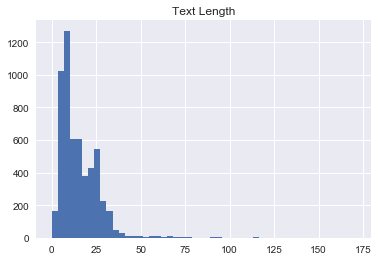

In [8]:
spamDf.hist('Text Length', bins=50)

### Identifying Embedding Size

In [9]:
MAX_SENT_SIZE = 35
MIN_WORD_FREQ = 3

vocabProcessor = learn.preprocessing.VocabularyProcessor(max_document_length=MAX_SENT_SIZE, min_frequency=MIN_WORD_FREQ)
wordIdx = vocabProcessor.fit_transform(spamDf['Content'])
embeddingSize = len(vocabProcessor.vocabulary_._mapping)
print(type(wordIdx))
embeddingSize

<class 'generator'>


2110

-----
**TEST**

-----

In [10]:
vocab = vocabProcessor.vocabulary_._mapping

In [11]:
print(type(vocab))
print(len(vocab.items()))

<class 'dict'>
2110


In [12]:
sortedVocab = sorted(vocab.items(), key=lambda i: i[1], reverse=True)

In [13]:
sortedVocab[: 10]

[('yuo', 2109),
 ('youclean', 2108),
 ('yer', 2107),
 ('xxxxxxx', 2106),
 ('xxxx', 2105),
 ('wylie', 2104),
 ('wwx', 2103),
 ('wwwringtonescouk', 2102),
 ('wwwldewcomwinppmxage', 2101),
 ('wtf', 2100)]

In [14]:
import itertools

list(itertools.islice(wordIdx, 2))

[array([  44,  457,    0,  811,  706,  669,   62,    9, 1234,   88,  121,
         367, 1053,  149,    0, 1240,   66,   55,    0,  136,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]),
 array([  47,  320, 1441,  460,    6, 1975,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])]

-----

### Embedding Matrix

In [15]:
embeddingMx = tf.convert_to_tensor(np.eye(embeddingSize, dtype=np.float32))
embeddingMx

<tf.Tensor 'Const:0' shape=(2110, 2110) dtype=float32>

### Declaring Parameters and Placeholders

In [16]:
W = tf.Variable(tf.truncated_normal(shape=[embeddingSize, 1]), name='W')
b = tf.Variable(tf.zeros(shape=[1, 1]), name='b')
print(W)
print(b)

X = tf.placeholder(shape=[MAX_SENT_SIZE], dtype=tf.int32, name='X')
y = tf.placeholder(shape=[1, 1], dtype=tf.float32, name='y')
print(X)
print(y)

Tensor("W/read:0", shape=(2110, 1), dtype=float32)
Tensor("b/read:0", shape=(1, 1), dtype=float32)
Tensor("X:0", shape=(35,), dtype=int32)
Tensor("y:0", shape=(1, 1), dtype=float32)


### Mapping Indices of Words

In [17]:
X_embed = tf.nn.embedding_lookup(embeddingMx, X, name='X_embed')
X_sums = tf.reduce_sum(X_embed, 0, name='X_sums')

print(X_embed)
print(X_sums)

Tensor("X_embed:0", shape=(35, 2110), dtype=float32)
Tensor("X_sums:0", shape=(2110,), dtype=float32)


### Calculating Outputs and Loss Function

In [18]:
X_sums_2D = tf.expand_dims(X_sums, 0, name='X_sums_2D')
output = tf.add(tf.matmul(X_sums_2D, W), b, name='output')
print(X_sums_2D)
print(output)

prediction = tf.sigmoid(output, name='prediction')
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=output, name='loss'))
print(prediction)
print(loss)

Tensor("X_sums_2D:0", shape=(1, 2110), dtype=float32)
Tensor("output:0", shape=(1, 1), dtype=float32)
Tensor("prediction:0", shape=(1, 1), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


### Training Step

In [19]:
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss, name='train')
print(train)

name: "train"
op: "NoOp"
input: "^train/update_W/ApplyGradientDescent"
input: "^train/update_b/ApplyGradientDescent"



### Initializing Variables

In [20]:
init = tf.global_variables_initializer()
sess.run(init)

### Training Data

In [21]:
for (i, x_item) in enumerate(vocabProcessor.fit_transform(trainData['Content'])):
    y_item = trainData.iloc[i]['Label']
    feedDict = {X: x_item, y: [[y_item]]}
    sess.run(train, feed_dict=feedDict)
    
    if (i + 1) % 200 == 0:
        lossRes = sess.run(loss, feed_dict=feedDict)
        print('#{0} - loss: {1}'.format(i, lossRes))

#199 - loss: 5.26112174987793
#399 - loss: 0.1965966671705246
#599 - loss: 0.0002463244891259819
#799 - loss: 0.5377370119094849
#999 - loss: 0.04413670301437378
#1199 - loss: 1.2901149375466048e-06
#1399 - loss: 0.04000787064433098
#1599 - loss: 0.056731242686510086
#1799 - loss: 2.860339641571045
#1999 - loss: 0.18568192422389984
#2199 - loss: 0.00024442761787213385
#2399 - loss: 0.8692538738250732
#2599 - loss: 0.0019671402405947447
#2799 - loss: 0.006754941772669554
#2999 - loss: 0.15233992040157318
#3199 - loss: 0.06440827250480652
#3399 - loss: 0.00046425487380474806
#3599 - loss: 0.022434046491980553
#3799 - loss: 4.0674599688372837e-08
#3999 - loss: 0.0016532299341633916
#4199 - loss: 0.7760111093521118
#4399 - loss: 0.0002145512553397566


### Measuring Test Set Accuracy

In [22]:
testAccuracy = []

for (i, x_item) in enumerate(vocabProcessor.fit_transform(testData['Content'])):
    y_item = testData.iloc[i]['Label']
    feedDict = {X: x_item, y: [[y_item]]}
    predictionRes = sess.run(prediction, feed_dict=feedDict)
    testAccuracy.append(y_item == np.round(predictionRes))
    
    if (i + 1) % 50 == 0:
        print('#{0} - accuracy: {1}:'.format(i, np.mean(testAccuracy)))

print('Overall Test Accuracy: {0}'.format(np.mean(testAccuracy)))

#49 - accuracy: 0.96:
#99 - accuracy: 0.87:
#149 - accuracy: 0.86:
#199 - accuracy: 0.875:
#249 - accuracy: 0.864:
#299 - accuracy: 0.8633333333333333:
#349 - accuracy: 0.8685714285714285:
#399 - accuracy: 0.8675:
#449 - accuracy: 0.8711111111111111:
#499 - accuracy: 0.862:
#549 - accuracy: 0.8636363636363636:
#599 - accuracy: 0.855:
#649 - accuracy: 0.8569230769230769:
#699 - accuracy: 0.8528571428571429:
#749 - accuracy: 0.8453333333333334:
#799 - accuracy: 0.84125:
#849 - accuracy: 0.84:
#899 - accuracy: 0.8377777777777777:
#949 - accuracy: 0.8389473684210527:
#999 - accuracy: 0.841:
#1049 - accuracy: 0.840952380952381:
#1099 - accuracy: 0.8409090909090909:
Overall Test Accuracy: 0.842152466367713
